# Histopathologic Cancer Detection with CNNs
CU Boulder MSDS

DTSA 5511 Week 3

# Step 1: Introduction

Machine learning has many potential applications; however, none are (to me) more rewarding than its applications in medicine. This particular project aims to identify metastatic cancer in small image patches (the center 32x32 pixels) taken from larger digital pathology scans (96x96 pixels). 

The dataset used in this project is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset. A positive label (1) indicates that the center of the image contains at least one pixel of tumor tissue, while a zero label indicates there is no tumor tissue present in the image. The outer pixels are present for padding and do not influence the label of the image. There are three parts of this dataset:
1) train folder -- containing training images
2) test folder -- containing testing images
3) train_labels.csv -- a file mapping training image names to labels

For this project, I am going to compare two CNN architectures: one very basic model, and another utilizing normalization layers (like BatchNormalization, etc).

In [1]:
# Let's include some libraries!
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import random, cv2
import warnings

# Plotting Tools
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam

# SKLearn Stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

2025-06-15 16:14:01.605153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750004041.669996    2767 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750004041.690698    2767 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
warnings.filterwarnings('ignore')

# Set a random seed for reproducability
np.random.seed(27)
tf.random.set_seed(27)

In [3]:
# Define the directories.
homeDir = '../input/histopathologic-cancer-detection'
labelsDir = os.path.join(homeDir,'train_labels.csv')
trainDir = os.path.join(homeDir,'train')
testDir = os.path.join(homeDir,'test')

print('There are ', len(os.listdir(trainDir)),'training images and ',
     len(os.listdir(testDir)), 'testing images.')

There are  220025 training images and  57458 testing images.


In [4]:
# Load the labels.
trainLabels = pd.read_csv(labelsDir)

print(f"Training labels shape: {trainLabels.shape}")
# Check out the class distribution.
classDist = trainLabels['label'].value_counts(normalize=True)*100
print(f"\nClass distribution (%):\n{classDist}")

Training labels shape: (220025, 2)

Class distribution (%):
label
0    59.496875
1    40.503125
Name: proportion, dtype: float64


In [5]:
# Now let's create a dataframe to match the training images with labels.
train = pd.DataFrame({'path': glob(os.path.join(trainDir,'*.tif'))})
train['id'] = train['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
train = train.merge(trainLabels, on='id')

# Convert the labels to strings 
# train['label'] = train['label'].astype(str)

# Aaaand ensure the paths are relative to the trainDir
train['path'] = train['path'].apply(lambda x: os.path.basename(x))

print(train.head())

                                           path  \
0  d43c081bafa286f9c1f7e921883f26ceafebc912.tif   
1  092d0eedebce504847715ee046b6ad74b57599b4.tif   
2  b0d2582c6218a8764323fc940b41312282b99bf4.tif   
3  187c99df762f13f99818e5593d4bab4c6577e7e3.tif   
4  7c5270c83837de5a5cbb2dca511559dc39d19d53.tif   

                                         id  label  
0  d43c081bafa286f9c1f7e921883f26ceafebc912      1  
1  092d0eedebce504847715ee046b6ad74b57599b4      0  
2  b0d2582c6218a8764323fc940b41312282b99bf4      0  
3  187c99df762f13f99818e5593d4bab4c6577e7e3      1  
4  7c5270c83837de5a5cbb2dca511559dc39d19d53      1  


# Step 2: Exploratory Data Analysis

We saw previously that there are 220,025 training images and 57,458 testing images. The training images are split into two categories: 0 (no cancer) and 1 (cancer). 59.5% of the images do not contain a tumor cell, and 40.5% do contain tumor cells. This is a slight imbalance in the dataset, suggesting we may need to apply **data augmentation or class weighting** to balance the model training.

In [6]:
# Check for null values and duplicate data.
# Note: there shouldn't be any duplicate data.
print('There are ',train.isnull().sum().sum(), ' null values.')
print('There are ',train.duplicated().sum(), ' duplicated images.')

There are  0  null values.
There are  0  duplicated images.


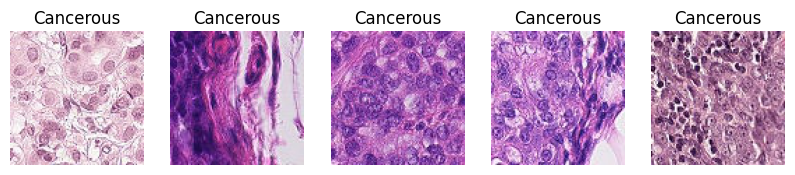

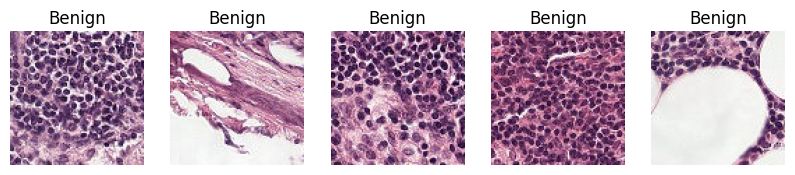

In [7]:
# Sample images from each class.
cancerous = train[train['label']==1]['id'].sample(5).values
nCancerous = train[train['label']==0]['id'].sample(5).values

cancerImgs = []
for id in cancerous:
    imgPath = os.path.join(trainDir,id+'.tif')
    cancerImgs.append(Image.open(imgPath))

nCancerImgs = []
for id in nCancerous:
    imgPath = os.path.join(trainDir,id+'.tif')
    nCancerImgs.append(Image.open(imgPath))

plt.figure(figsize=(10,5))
for ii, image in enumerate(cancerImgs):
    plt.subplot(1,5,ii+1)
    plt.imshow(image)
    plt.title('Cancerous')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10,5))
for ii, image in enumerate(nCancerImgs):
    plt.subplot(1,5,ii+1)
    plt.imshow(image)
    plt.title('Benign')
    plt.axis('off')
plt.show()

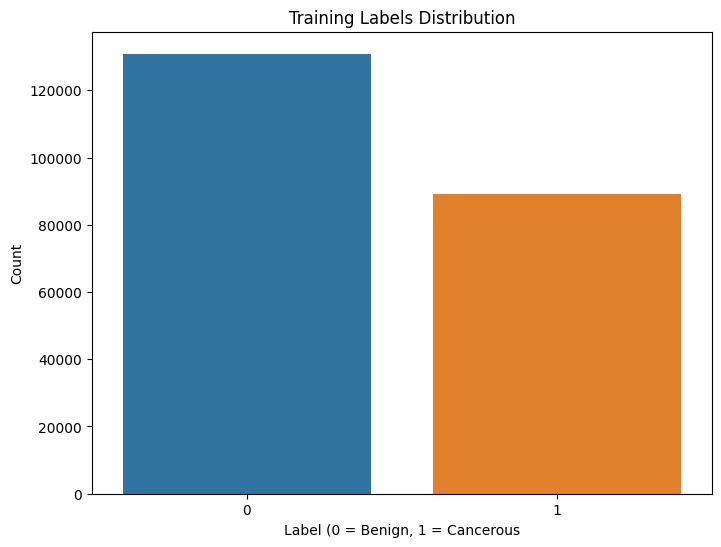

In [8]:
# Let's also plot the distribution of the labels.
plt.figure(figsize=(8,6))
sns.countplot(x='label',data=trainLabels)
plt.title("Training Labels Distribution")
plt.xlabel('Label (0 = Benign, 1 = Cancerous')
plt.ylabel('Count')
plt.show()

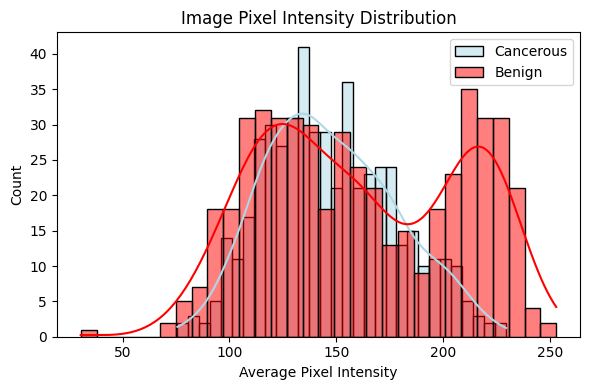

In [9]:
# Let's look at a distribution of the image intensities.
cancerous = train[train['label']==1]['id'].sample(500).values
nCancerous = train[train['label']==0]['id'].sample(500).values

cancerInts = []
for id in cancerous:
    imgPath = os.path.join(trainDir,id+'.tif')
    img = cv2.imread(imgPath,cv2.IMREAD_GRAYSCALE)
    cancerInts.append(np.mean(img))

nCancerInts = []
for id in nCancerous:
    imgPath = os.path.join(trainDir,id+'.tif')
    img = cv2.imread(imgPath,cv2.IMREAD_GRAYSCALE)
    nCancerInts.append(np.mean(img))


plt.figure(figsize=(6,4))
sns.histplot(cancerInts,bins=30,kde=True,color='lightblue',label='Cancerous')
sns.histplot(nCancerInts,bins=30,kde=True,color='red',label='Benign')
plt.title('Image Pixel Intensity Distribution')
plt.ylabel('Count')
plt.xlabel('Average Pixel Intensity')
plt.legend()
plt.tight_layout()
plt.show()

## EDA Conclusions

The data is split about 60/40 noncancerous vs. cancerous. While it's not completely equal, it's not a crazy difference (if only 5% of the images were cancerous, for example, this would be a much harder problem). We still might need to apply some class weighting or data augmentation to this model, though.

The images have varying intensities and intensity distributions, with a wide variety of colors in each. We can see an approximate bimodal distribution of average pixel intensity for the benign images, and a unimodal (almost Gaussian-looking) distribution for the cancerous images. However, the average pixel intensities overlap quite a bit, so this alone could not distinguish the classes.

# Step 3: Model Creation
Here I am going to test two models: one a very basic model, where I will extract and feed only the center 32x32 pixels of the images to the model, and the second with some more advanced techniques, including Gaussian smoothing.

But let's start with the basics: splitting the data!

In [10]:
# Split the data into training and validation.
trainDF, valDF = train_test_split(train,test_size=0.2,random_state=27)
print('There are', len(trainDF), 'training images.')
print('There are',len(valDF),'validation images.')

There are 176020 training images.
There are 44005 validation images.


## Step 3a: Basic Model

For this model, I am going to crop and scale the images within the model and then create a very basic CNN with 2 convolutional blocks.

We're going to select the best model using hyperparameter tuning on a small subset of the images (50% cancer, 50% benign).

In [11]:
def loadImage(imgID,imgDir=trainDir):
    path = os.path.join(imgDir,imgID+'.tif')

    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    return img

In [12]:
# Use only 5% of images of both labels to tune the model
nSubset = int(train.shape[0]*0.05)

benign = train[train['label']==0].sample(nSubset)
cancer = train[train['label']==1].sample(nSubset)

allTogether = pd.concat([benign,cancer],axis=0).reset_index(drop=True)

allLabels = allTogether.sample(frac=1).reset_index(drop=True)

In [13]:
# Load images for tuning
trainSubset = np.array([loadImage(ii) for ii in allLabels['id']])
labelSubset = allLabels['label'].values

In [14]:
# Create the model & run through the tuner to find best hyperparameters.
def createBase(hp):
    model = models.Sequential([
        # Convolutional Block 1
        layers.Input(shape=(96,96,3)),
        layers.Rescaling(1./255),
        layers.Cropping2D(cropping=32),
        layers.Conv2D(32,(3,3),activation='relu'),
        layers.MaxPooling2D(2,2),

        # Convolutional Block 2
        layers.Conv2D(hp.Int('conv_units',64,128,step=64),(3,3),
                      activation='relu'),
        layers.MaxPooling2D(2,2),

        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(hp.Int('dense_units',128,256,step=128),
                    activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(1,activation='sigmoid')
    
    ])

    model.compile(
        optimizer = Adam(hp.Choice('learning_rate',[1e-4, 1e-3])),
        loss='binary_crossentropy',
        metrics=['accuracy',tf.keras.metrics.AUC()]
    )

    return model

# Make the tuner
baseTuner = kt.RandomSearch(
    createBase,
    objective='val_accuracy',
    directory='baseTuning'
)

baseTuner.search(trainSubset,labelSubset,validation_split=0.2,epochs=10)

Reloading Tuner from baseTuning/untitled_project/tuner0.json


2025-06-15 16:15:11.035088: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [15]:
baseTuner.results_summary()

Results summary
Results in baseTuning/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
conv_units: 64
dense_units: 256
learning_rate: 0.0001
Score: 0.7745966911315918

Trial 02 summary
Hyperparameters:
conv_units: 128
dense_units: 128
learning_rate: 0.001
Score: 0.7741422653198242

Trial 05 summary
Hyperparameters:
conv_units: 128
dense_units: 256
learning_rate: 0.0001
Score: 0.7725517153739929

Trial 07 summary
Hyperparameters:
conv_units: 128
dense_units: 256
learning_rate: 0.001
Score: 0.7723244428634644

Trial 06 summary
Hyperparameters:
conv_units: 64
dense_units: 128
learning_rate: 0.001
Score: 0.771642804145813

Trial 03 summary
Hyperparameters:
conv_units: 64
dense_units: 256
learning_rate: 0.001
Score: 0.7707339525222778

Trial 01 summary
Hyperparameters:
conv_units: 128
dense_units: 128
learning_rate: 0.0001
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/s

In [16]:
bestBase = baseTuner.get_best_models(num_models=1)[0]
bestBase.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d (Cropping2D)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 609,729 (2.33 MB)

 Trainable params: 609,729 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

## Step 3b: The Fancy CNN

For this model, I'm going to add another layer and batch normalization to improve the training speed and stability of the network by reducing overfitting. Batch normalization in particular can act as a regularizer by normalizing the layer inputs.

In [17]:
# Now to create the model
def createFancy(hp):
    model = models.Sequential([
        # Convolutional Block 1
        layers.Input(shape=(96,96,3)),
        layers.Rescaling(1./255),
        layers.Cropping2D(cropping=32),
        layers.Conv2D(32,(3,3),padding='same',activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        # Convolutional Block 2
        layers.Conv2D(64,(3,3),padding='same',activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        # Convolutional Block 3
        layers.Conv2D(128,(3,3),padding='same',activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(hp.Int('dense',64,256,step=64),activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(1,activation='sigmoid')
    
    ])

    model.compile(
        optimizer = Adam(hp.Choice('learning_rate',[1e-4,1e-3])),
        loss='binary_crossentropy',
        metrics=['accuracy',tf.keras.metrics.AUC()]
    )

    return model

fancyTuner = kt.RandomSearch(
    createFancy,
    objective='val_accuracy',
    directory='fancyTuning'
)

fancyTuner.search(trainSubset,labelSubset,validation_split=0.2,epochs=10)

Trial 7 Complete [00h 05m 32s]
val_accuracy: 0.7841399908065796

Best val_accuracy So Far: 0.7864121794700623
Total elapsed time: 00h 44m 41s


In [18]:
fancyTuner.results_summary()

Results summary
Results in fancyTuning/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
dense: 64
learning_rate: 0.001
Score: 0.7864121794700623

Trial 03 summary
Hyperparameters:
dense: 64
learning_rate: 0.0001
Score: 0.7843672037124634

Trial 06 summary
Hyperparameters:
dense: 128
learning_rate: 0.0001
Score: 0.7841399908065796

Trial 01 summary
Hyperparameters:
dense: 128
learning_rate: 0.001
Score: 0.7789138555526733

Trial 00 summary
Hyperparameters:
dense: 256
learning_rate: 0.0001
Score: 0.7786866426467896

Trial 05 summary
Hyperparameters:
dense: 192
learning_rate: 0.0001
Score: 0.7786866426467896

Trial 04 summary
Hyperparameters:
dense: 192
learning_rate: 0.001
Score: 0.7573278546333313


In [19]:
bestFancy = fancyTuner.get_best_models(num_models=1)[0]
bestFancy.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d (Cropping2D)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,601 (881.25 KB)

 Trainable params: 225,025 (879.00 KB)

 Non-trainable params: 576 (2.25 KB)

## Model Creation Conclusions

It looks like the "fancy" model achieves a slightly higher validation accuracy with fewer parameters. Let's train the best version of the "fancy" model on the full dataset, using callbacks like EarlyStopping and ReduceLROnPlateau to prevent overfitting.

# Step 4: Train the Model!

## Step 4a: Create some Callbacks.

Callbacks are pretty powerful tools in Keras that allow us to customize the behavior of our model during training, evaluation, and/or inference. We can use them to monitor metrics, stop the training early, adjust the learning rate, and so much more!

In [23]:
# Create the dataframes for training.
tTrain = np.array([loadImage(ii) for ii in train['id']])
lLabels = train['label'].values

In [24]:
# Callbacks 
aintNoHollaBacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )
]

baseSave = callbacks.ModelCheckpoint(
    filepath='bestBaseModel.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

fancySave = callbacks.ModelCheckpoint(
    filepath='bestFancyModel.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

## Step 4b: Train them Models!

In [27]:
# Train the fancy model.
print('Training Fancy CNN...')
bestHyper = fancyTuner.get_best_hyperparameters(num_trials=1)[0]
bestFancy = createFancy(bestHyper)

fancyHist = bestFancy.fit(
    tTrain,
    lLabels,
    epochs=10,
    validation_split=0.2,
    callbacks=[aintNoHollaBacks, fancySave]
)

Training Fancy CNN...
Epoch 1/20
5500/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7756 - auc_4: 0.8358 - loss: 0.4966
Epoch 1: val_accuracy improved from -inf to 0.69592, saving model to bestFancyModel.keras
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 324s 58ms/step - accuracy: 0.7756 - auc_4: 0.8358 - loss: 0.4965 - val_accuracy: 0.6959 - val_auc_4: 0.7786 - val_loss: 0.5924 - learning_rate: 0.0010
Epoch 2/20
5500/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8111 - auc_4: 0.8793 - loss: 0.4241
Epoch 2: val_accuracy improved from 0.69592 to 0.71187, saving model to bestFancyModel.keras
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 315s 57ms/step - accuracy: 0.8112 - auc_4: 0.8793 - loss: 0.4241 - val_accuracy: 0.7119 - val_auc_4: 0.8081 - val_loss: 0.5726 - learning_rate: 0.0010
Epoch 3/20
5500/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8267 - auc_4: 0.8946 - loss: 0.3977
Epoch 3: val_accuracy improved from 0.71187 to 0.78280, saving model to bestFancyModel.keras
5501/5501 ━━━━━━━━━━━━━

KeyboardInterrupt: 

# Step 5: Evaluate Model Performance
Now for the fun part! Let's see how our model performed!

NameError: name 'fancyHist' is not defined

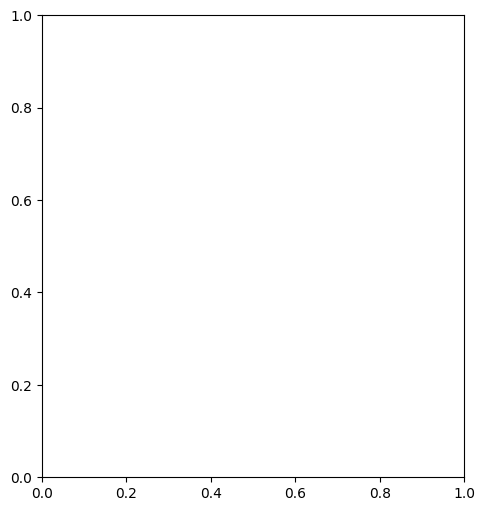

In [28]:
# Accuracy & Loss Curves
plt.figure(figsize=(12,6))

# Accuracy
plt.subplot(1,2,1)
plt.plot(fancyHist.history['accuracy'],label='Train')
plt.plot(fancyHist.history['val_accuracy'],label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(fancyHist.history['loss'],label='Train')
plt.plot(fancyHist.history['val_loss'],label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step


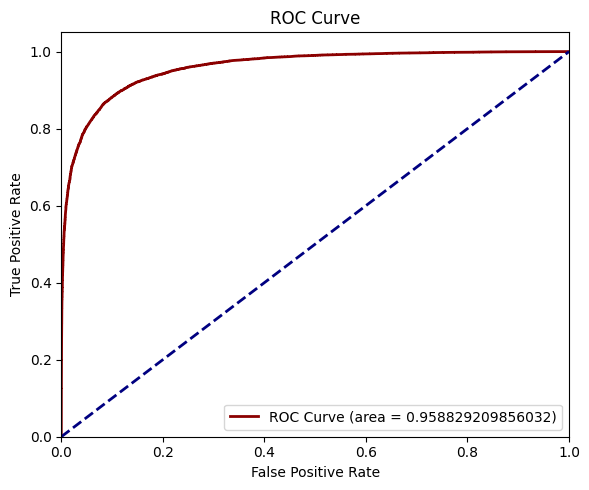

In [38]:
# Get true labels and the model predictions
valSet = tTrain[:int(tTrain.shape[0]*0.2)]
valLabel = lLabels[:int(tTrain.shape[0]*0.2)]

yPred = bestFancy.predict(valSet)
yPred = yPred.ravel()
yPredClass = (yPred > 0.5).astype(int).flatten()

# Plot ROC curve
fpr,tpr, _ = roc_curve(valLabel,yPred)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr,tpr,color='darkred',lw=2,label=f'ROC Curve (area = {roc_auc})')
plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

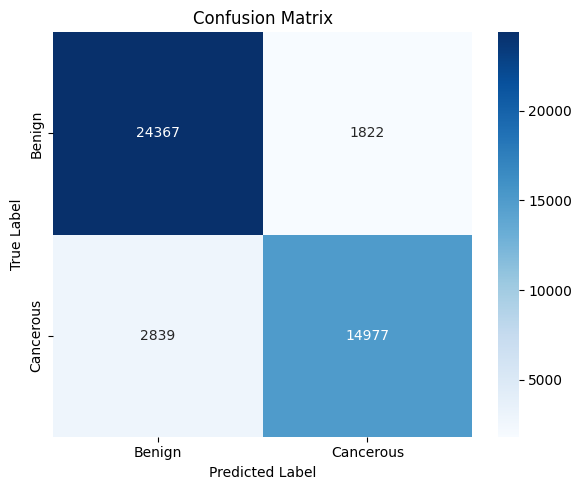

In [39]:
# Generate and plot confusion matrix.
cm = confusion_matrix(valLabel,yPredClass)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap = 'Blues',
    xticklabels=['Benign','Cancerous'],
    yticklabels=['Benign','Cancerous']
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [40]:
# Generate classification report.
print(classification_report(valLabel,yPredClass))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     26189
           1       0.89      0.84      0.87     17816

    accuracy                           0.89     44005
   macro avg       0.89      0.89      0.89     44005
weighted avg       0.89      0.89      0.89     44005



## Model Analysis Conclusions

The model predicts well, getting about 90% accuracy with decent precision and recall. The f1 score is higher for benign classifications, which I think makes a bit of sense because there are more benign training labels than cancerous ones. We can also see that the misclassifcation rates are low for both classes (as seen in the confusion matrix) and that the model performs much better than the nominal model, as shown by the ROC curve.

# Step 6: Submission

In [42]:
# Create generator for test data
testFiles = os.listdir(testDir)
test = pd.DataFrame({
    'id':[os.path.splitext(file)[0] for file in testFiles],
    'filename': testFiles
})

tTest = np.array([loadImage(ii,imgDir=testDir) for ii in test['id']])


In [43]:
# Now predict!
print('Generating predictions for submission!')
preds = bestFancy.predict(tTest)

preds = preds.ravel()
predClass = (preds > 0.5).astype(int).flatten()

Generating predictions for submission!
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step


In [44]:
# Save submission.
subDF = pd.DataFrame({
    'id': test['id'][:len(preds)],
    'label': preds
})

subDF.to_csv('submissionCancer.csv',index=False)
print('Submission saved!')

Submission saved!


# Step 7: Ultimate Conclusions!

## 7a: Summary
In this project, we detected metastatic cancer in patches of images from digital pathology scans using two CNNs: a basic 2 block CNN and a more advanced 3 block CNN with batch normalization.

## 7b: Results
The "fancy" model, using batch normalization, yielded more accurate results than the basic model; however, both models learned to detect metastatic cancer with very good accuracy.

The batch normalization improved the "fancy" model's performance by normalizing the activations within each batch, allowing the model to better handle the variation in tissue staining & color intensity.

## 7c: Further Work
In the future, one might attempt some other spatial filters to help the model focus on areas of particular interest. One could also try adding other layers, or additional forms of normalization, to see if these steps would improve the models' accuracy.

# References
These notebooks helped me get started:
https://www.kaggle.com/code/carlosmatherson/cnn-architecture-comparison-for-histopathology

https://www.kaggle.com/code/michaelgrybko/cnn-cancer-detection

https://www.kaggle.com/code/vikkach/cancer-detection-cnn